## Data handling

In [70]:
import pandas as pd
import glob
df = pd.read_csv('Agg_GridFlexHeetenDataset_full_10min.csv')

In [32]:
df.head()

Q1 = df['consumption_kwh'].quantile(0.25)
Q3 = df['consumption_kwh'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
print('Length of the original dataframe: ', len(df))
df_clean = df[(df['consumption_kwh'] >= lower_bound) & (df['consumption_kwh'] <= upper_bound)]
print('Length of the cleaned dataframe: ', len(df_clean))
print('Difference in length: ', str(len(df) - len(df_clean)))

Lower Bound: -0.06500000000596634, Upper Bound: 0.15100000000893485
Length of the original dataframe:  7269187
Length of the cleaned dataframe:  6511487
Difference in length:  757700


In [58]:
df_clean['time_10min'] = pd.to_datetime(df_clean['time_10min'])
df_group_10_min = df_clean.groupby('time_10min')['consumption_kwh'].sum().reset_index()

/var/folders/vw/rm1q12851jq6ww7xsgf4g0x00000gn/T/ipykernel_13825/429706352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['time_10min'] = pd.to_datetime(df_clean['time_10min'])


In [63]:
df_group_10_min['month'] = df_group_10_min['time_10min'].dt.month
df_group_10_min['hour'] = df_group_10_min['time_10min'].dt.hour

group_means = (
    df_group_10_min[df_group_10_min['consumption_kwh'] >= 0]
    .groupby(['month', 'hour'])['consumption_kwh']
    .mean()
    .reset_index()
    .rename(columns={'consumption_kwh': 'mean_consumption'})
)

In [64]:
df_group_10_min.columns

Index(['time_10min', 'consumption_kwh', 'month', 'hour', 'mean_consumption_x',
       'mean_consumption_y'],
      dtype='object')

In [65]:
df_group_10_min = df_group_10_min.merge(group_means, on=['month', 'hour'], how='left')
df_group_10_min.loc[df_group_10_min['consumption_kwh'] < 0, 'consumption_kwh'] = df_group_10_min.loc[df_group_10_min['consumption_kwh'] < 0, 'mean_consumption']
df_group_10_min.drop(columns=['mean_consumption', 'month', 'hour'], inplace=True)

/var/folders/vw/rm1q12851jq6ww7xsgf4g0x00000gn/T/ipykernel_13825/50514365.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


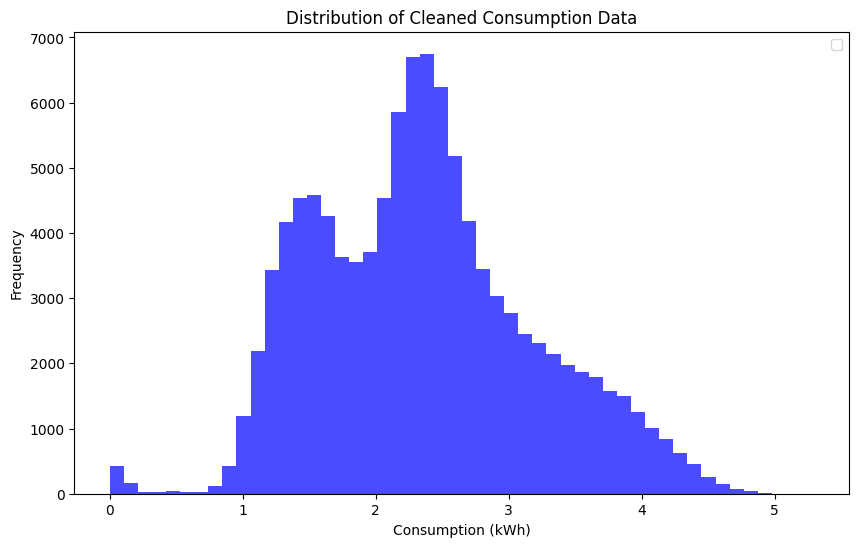

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_group_10_min['consumption_kwh'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cleaned Consumption Data')
plt.xlabel('Consumption (kWh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [72]:
import os

In [78]:
def load_prices(price_dir: list[str]) -> pd.DataFrame:
    all_files = glob.glob(os.path.join(price_dir, "*.csv"))
    all_files = [f for f in all_files if f.startswith(price_dir + 'GUI') and f.endswith('.csv')]
    dfs = []
    for file in all_files:
        df = pd.read_csv(file)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df['start_time'] = df['MTU (CET/CEST)'].apply(lambda x: x.split('-')[0].strip())
    df['end_time'] = df['MTU (CET/CEST)'].apply(lambda x: x.split('-')[1].strip())
    df['start_time'] = df['start_time'].astype(str).str.replace(r'\(.*\)', '', regex=True)
    df['end_time'] = df['end_time'].astype(str).str.replace(r'\(.*\)', '', regex=True)
    df['start_time'] = pd.to_datetime(df['start_time'], format='mixed')
    df['end_time'] = pd.to_datetime(df['end_time'], format='mixed')
    df = df[['Day-ahead Price (EUR/MWh)', 'start_time', 'end_time']]
    df.sort_values(by='start_time', inplace=True)
    return df


def load_data(df_consumption: pd.DataFrame, price_dir: str) -> pd.DataFrame:
    df_c = df_consumption.copy()
    df_c['time_10min'] = pd.to_datetime(df_c['time_10min'])
    df_p = load_prices(price_dir)
    df_c['year'] = df_c['time_10min'].dt.year
    df_c['month'] = df_c['time_10min'].dt.month
    df_c['day'] = df_c['time_10min'].dt.day
    df_c['hour'] = df_c['time_10min'].dt.hour
    df_p['year'] = df_p['start_time'].dt.year
    df_p['month'] = df_p['start_time'].dt.month
    df_p['day'] = df_p['start_time'].dt.day
    df_p['hour'] = df_p['start_time'].dt.hour
    merged = pd.merge(
        df_c,
        df_p,  
        on=['year', 'month', 'day', 'hour'],
        how='left',
        suffixes=('_cons', '_price')
    )
    merged = merged.drop(columns=['year', 'month', 'day', 'hour'])
    merged.to_csv('data/merged_data.csv', index=False)
    merged['consumption_kwh'] = merged['consumption_kwh'].astype(float) * 30
    return merged[['time_10min', 'consumption_kwh','Day-ahead Price (EUR/MWh)']]

In [113]:
df_combined = load_data(df_group_10_min, 'data_prices/')

In [114]:
df_combined.rename(columns={'Day-ahead Price (EUR/MWh)': 'price_eur_per_kwh', 'time_10min':'timestamp'}, inplace=True)

df_combined['price_eur_per_kwh'] = df_combined['price_eur_per_kwh'].astype(float) / 1000  # Convert EUR/MWh to EUR/kWh
df_combined['consumption_kwh'] = df_combined['consumption_kwh'].astype(float) * 15

In [115]:
df_combined.to_csv('data/consumption_prices_10min.csv', index=False)

In [116]:
df_combined.head()

,timestamp,consumption_kwh,price_eur_per_kwh
0,2018-08-01 02:00:00,960.75,0.01511
1,2018-08-01 02:10:00,1287.00,0.01511
2,2018-08-01 02:20:00,1238.40,0.01511
3,2018-08-01 02:30:00,1187.55,0.01511
4,2018-08-01 02:40:00,1087.20,0.01511


## Baseline

In [119]:
import pandas as pd

df = pd.read_csv('data/consumption_prices_10min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['price'] = df['price_eur_per_kwh'].astype(float)

financial_result = sum(df['price'] *df['consumption_kwh'] * -1)
financial_result

-4693951.06483048

## Heuristic approach

In [ ]:
import pandas as pd

def heuristic_trading_simulation(file_path):
    """
    Simulates an energy trading strategy for a Tesla Megapack based on a heuristic approach.

    This function loads a dataset of energy consumption and prices, and then simulates
    the charging and discharging of a Tesla Megapack battery. The strategy is to buy
    energy when the price is in the lowest 20% of the last 24 hours and sell when
    it's in the highest 20%. It also prioritizes using the battery to meet
    energy consumption needs.

    Args:
        file_path (str): The path to the CSV file containing the energy data.
                         The file should have 'timestamp', 'consumption', and 'price' columns.

    Returns:
        A tuple containing:
        - float: The total financial result from buying and selling energy.
        - float: The total number of battery cycles during the simulation.
    """
    try:
        data = pd.read_csv(file_path)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data['price'] = data['price_eur_per_kwh']
    except FileNotFoundError:
        print(f"{file_path} was not found.")
        return None, None

    megapack_capacity_kwh = 39160.0
    megapack_power_kw = 9790.0
    charge_per_10_min = megapack_power_kw * (10 / 60)
    battery_soc_kwh = 0.0 
    financial_result = 0.0
    total_charged = 0.0
    buy_history = []
    sell_history = []

    for i in range(len(data)):
        past_24h = data[data['timestamp'] < data['timestamp'][i]].tail(144)
        if not past_24h.empty:
            low_price_threshold = past_24h['price'].quantile(0.3)
            high_price_threshold = past_24h['price'].quantile(0.8)
        else:
            low_price_threshold = data['price'][i]
            high_price_threshold = data['price'][i]
            
        current_price = data['price'][i]
        consumption = data['consumption_kwh'][i]
        if battery_soc_kwh >= consumption:
            battery_soc_kwh -= consumption
        else:
            grid_pull = consumption - battery_soc_kwh
            battery_soc_kwh = 0
            financial_result -= grid_pull * current_price
            buy_history.append(grid_pull * current_price)

        if current_price <= low_price_threshold:
            charge_amount = min(charge_per_10_min, megapack_capacity_kwh - battery_soc_kwh)
            battery_soc_kwh += charge_amount
            financial_result -= charge_amount * current_price
            buy_history.append(charge_amount * current_price)
            total_charged += charge_amount
            
        elif current_price >= high_price_threshold:
            discharge_amount = min(charge_per_10_min, battery_soc_kwh)
            battery_soc_kwh -= discharge_amount
            financial_result += discharge_amount * current_price
            sell_history.append(discharge_amount * current_price)

    battery_cycles = total_charged / megapack_capacity_kwh if megapack_capacity_kwh > 0 else 0
    return financial_result, battery_cycles

if __name__ == '__main__':
    dataset_path = 'data/consumption_prices_10min.csv'
    final_profit, total_cycles = heuristic_trading_simulation(dataset_path)
    if final_profit is not None and total_cycles is not None:
        print("--- Heuristic Trading Simulation Results ---")
        print(f"Total Financial Result: ${final_profit:,.2f}")
        print(f"Total Battery Cycles: {total_cycles:.2f}")
        print("------------------------------------------")

--- Heuristic Trading Simulation Results ---
Total Financial Result: $-4,435,484.10
Total Battery Cycles: 1408.77
------------------------------------------


In [122]:
total_profit_over_baseline = final_profit - financial_result
total_profit_over_baseline

np.float64(258466.9638935551)

## PPO approach

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
from gym import spaces
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
df = pd.read_csv('data/consumption_prices_10min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['price_lag_1'] = df['price_eur_per_kwh'].shift(1)
df['price_lag_6'] = df['price_eur_per_kwh'].shift(6)
df['price_ma_24h'] = df['price_eur_per_kwh'].rolling(window=144).mean()
df.fillna(method='bfill', inplace=True)

CAP_KWH             = 39160.0   
MAX_PWR_KW          =   9790.0  
class BatteryEnv(gym.Env):
    """
    Custom Gym environment for the battery energy trading problem.
    """
    def __init__(self, df, battery_capacity_kwh=39160, max_charge_rate_kw=9790.0, max_discharge_rate_kw=9790.0, efficiency=1.0):
        super(BatteryEnv, self).__init__()

        self.df = df
        self.battery_capacity_kwh = battery_capacity_kwh
        self.max_charge_energy = max_charge_rate_kw * (10/60)
        self.max_discharge_energy = max_discharge_rate_kw * (10/60)
        self.efficiency = efficiency
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(10,), dtype=np.float32)
        self.current_step = 0
        self.reset()

    def reset(self):
        self.current_step = 0
        self.state_of_charge = self.battery_capacity_kwh / 2
        self.cumulative_profit = 0
        self.total_cycles = 0
        return self._get_observation()

    def _get_observation(self):
        soc_normalized = (self.state_of_charge / self.battery_capacity_kwh) * 2 - 1
        data_row = self.df.iloc[self.current_step]
        
        # Normalize all features for the NN
        price_mean = self.df['price_eur_per_kwh'].mean()
        price_std = self.df['price_eur_per_kwh'].std()
        consumption_mean = self.df['consumption_kwh'].mean()
        consumption_std = self.df['consumption_kwh'].std()

        price_normalized = (data_row['price_eur_per_kwh'] - price_mean) / price_std
        consumption_normalized = (data_row['consumption_kwh'] - consumption_mean) / consumption_std
        price_lag_1_normalized = (data_row['price_lag_1'] - price_mean) / price_std
        price_lag_6_normalized = (data_row['price_lag_6'] - price_mean) / price_std
        price_ma_normalized = (data_row['price_ma_24h'] - price_mean) / price_std

        obs = np.array([
            soc_normalized,
            price_normalized,
            consumption_normalized,
            data_row['hour_sin'],
            data_row['hour_cos'],
            data_row['day_of_week_sin'],
            data_row['day_of_week_cos'],
            price_lag_1_normalized,
            price_lag_6_normalized,
            price_ma_normalized
        ], dtype=np.float32)
        return obs
    
    def step(self, action):
        price = self.df['price_eur_per_kwh'].iloc[self.current_step]
        consumption = self.df['consumption_kwh'].iloc[self.current_step]
        # --- START OF CHANGE 3: Revamped Reward Function ---
        price_baseline = self.df['price_ma_24h'].iloc[self.current_step] # Use MA as baseline
        reward = 0

        # 1. Apply consumption
        self.state_of_charge -= consumption
        if self.state_of_charge < 0:
            energy_needed = -self.state_of_charge
            self.cumulative_profit -= energy_needed * price # Real cost
            self.state_of_charge = 0
            reward -= 50 # High penalty for forced grid purchase

        # 2. Execute agent's action
        if action == 0:  # Sell
            energy_to_sell = min(self.max_discharge_energy, self.state_of_charge)
            if energy_to_sell > 0:
                self.state_of_charge -= energy_to_sell
                revenue = energy_to_sell * price
                self.cumulative_profit += revenue
                
                # Reward is based on selling above the baseline price
                reward += (price - price_baseline) * energy_to_sell
                
                # Apply degradation cost
                cycle_fraction = energy_to_sell / self.battery_capacity_kwh
                self.total_cycles += cycle_fraction
                reward -= cycle_fraction * self.battery_capacity_kwh

        elif action == 1:  # Buy
            energy_to_buy = min(self.max_charge_energy, self.battery_capacity_kwh - self.state_of_charge)
            if energy_to_buy > 0:
                energy_added = energy_to_buy * self.efficiency
                self.state_of_charge += energy_added
                cost = energy_to_buy * price
                self.cumulative_profit -= cost
                
                # Reward is based on buying below the baseline price
                reward += (price_baseline - price) * energy_to_buy
                
                # Apply degradation cost
                cycle_fraction = energy_to_buy / self.battery_capacity_kwh
                self.total_cycles += cycle_fraction
                reward -= cycle_fraction * self.battery_capacity_kwh
        
        elif action == 2: # Hold
            pass        
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        info = {
            'cumulative_profit': self.cumulative_profit,
            'state_of_charge': self.state_of_charge,
            'total_cycles': self.total_cycles
        }

        return self._get_observation(), reward, done, info
    
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        return action.item(), action_logprob

    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        return action_logprobs, torch.squeeze(state_value), dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, lr, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.MseLoss = nn.MSELoss()

    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).detach()).to(device)
        old_actions = torch.squeeze(torch.stack(memory.actions).detach()).to(device)
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs).detach()).to(device)
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.05*dist_entropy
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

# --- 4. Training Loop ---
def train():
    # Hyperparameters
    update_timestep = 1024 # update policy every n timesteps
    K_epochs = 80          # update policy for K epochs
    eps_clip = 0.2         # clip parameter for PPO
    gamma = 0.99           # discount factor
    lr = 0.0003            # learning rate for adam
    max_episodes = 50      # number of episodes to train for

    env = BatteryEnv(df)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    memory = Memory()
    ppo = PPO(state_dim, action_dim, lr, gamma, K_epochs, eps_clip)

    time_step = 0
    episode_rewards = []
    
    print("Starting Training...")
    for i_episode in range(1, max_episodes + 1):
        state = env.reset()
        state = torch.from_numpy(state).float().to(device)
        episode_reward = 0
        for t in tqdm(range(len(df)-1), desc=f"Episode {i_episode}/{max_episodes}"):
            time_step += 1
            # Running policy_old:
            action, logprob = ppo.policy_old.act(torch.FloatTensor(state).to(device))
            state, reward, done, _ = env.step(action)
            # Saving reward and is_terminals:
            memory.actions.append(torch.tensor(action))
            memory.states.append(torch.FloatTensor(state))
            memory.logprobs.append(logprob)
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            # update if its time
            if time_step % update_timestep == 0:
                ppo.update(memory)
                memory.clear_memory()
                time_step = 0
                
            episode_reward += reward
            if done:
                break
        
        episode_rewards.append(episode_reward)
        print(f"Episode {i_episode} \t Last reward: {episode_reward:.2f}")

    print("Training finished.")
    return ppo, episode_rewards

# --- 5. Evaluation and Visualization ---
def evaluate(ppo_agent, df):
    print("\nStarting Evaluation...")
    env = BatteryEnv(df)
    state = env.reset()
    
    history = {
        'profit': [],
        'soc': [],
        'action': [],
        'price': [],
        'consumption': []
    }
    
    for t in tqdm(range(len(df)-1), desc="Evaluating"):
        action, _ = ppo_agent.policy.act(torch.FloatTensor(state))
        state, _, done, info = env.step(action)
        
        history['profit'].append(info['cumulative_profit'])
        history['soc'].append(info['state_of_charge'])
        history['action'].append(action)
        history['price'].append(df['price_eur_per_kwh'].iloc[t])
        history['consumption'].append(df['consumption_kwh'].iloc[t])

        if done:
            break
            
    # Final performance metrics
    final_profit = history['profit'][-1]
    final_cycles = env.total_cycles
    print(f"\nEvaluation Complete.")
    print(f"Final Cumulative Profit: {final_profit:.2f} EUR")
    print(f"Total Battery Cycles: {final_cycles:.2f}")

    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('PPO Agent Performance Evaluation', fontsize=16)

    axs[0].plot(history['profit'], label='Cumulative Profit', color='green')
    axs[0].set_ylabel('Profit (EUR)')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(history['soc'], label='State of Charge (SoC)', color='blue')
    axs[1].set_ylabel('SoC (kWh)')
    axs[1].legend(loc='upper left')
    
    ax2 = axs[1].twinx()
    buy_indices = [i for i, a in enumerate(history['action']) if a == 1]
    sell_indices = [i for i, a in enumerate(history['action']) if a == 0]
    ax2.plot(buy_indices, [history['price'][i] for i in buy_indices], 'go', markersize=4, label='Buy Action')
    ax2.plot(sell_indices, [history['price'][i] for i in sell_indices], 'ro', markersize=4, label='Sell Action')
    ax2.set_ylabel('Price at Action (EUR/kWh)')
    ax2.legend(loc='upper right')

    axs[2].plot(history['price'], label='Market Price', color='orange', alpha=0.7)
    axs[2].set_ylabel('Price (EUR/kWh)')
    ax3 = axs[2].twinx()
    ax3.plot(history['consumption'], label='Consumption', color='purple', alpha=0.6)
    ax3.set_ylabel('Consumption (kWh)')
    axs[2].set_xlabel('Timestep (10 min intervals)')
    lines, labels = axs[2].get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    axs[2].legend(lines + lines2, labels + labels2, loc='upper left')
    axs[2].grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


if __name__ == '__main__':
    trained_ppo, rewards = train()
    evaluate(trained_ppo, df)


/var/folders/vw/rm1q12851jq6ww7xsgf4g0x00000gn/T/ipykernel_13825/1733437982.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Starting Training...


Episode 1/50:   0%|          | 0/105543 [00:00<?, ?it/s]


TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=mps:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [100]:
%pip install gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 18.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827725 sha256=4332498b759cf45fa851af34dad0c188b21338a7027959d0e5b5d7b2bac8e293
  Stored in directory: /Users/szymonkozak/Library/Caches/pip/wheels/1d/34/c6/856a1e1eff47d8f18545c833b6138ae1e9f53c7de9bcc5f31d
Successfully built gym
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gym]
Note: you may need to restart the kernel to use updated packages.


In [126]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
from gym import spaces
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device('mps' if torch.backends.mps.is_available() else (
    'cuda' if torch.cuda.is_available() else 'cpu'))
print(f"Using device: {device}")


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv('data/consumption_prices_10min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['price_lag_1'] = df['price_eur_per_kwh'].shift(1)
df['price_lag_6'] = df['price_eur_per_kwh'].shift(6)
df['price_ma_24h'] = df['price_eur_per_kwh'].rolling(window=144).mean()
df.fillna(method='bfill', inplace=True)

CAP_KWH = 39160.0
MAX_PWR_KW = 9790.0


class BatteryEnv(gym.Env):
    """Custom Gym environment for the battery energy trading problem."""

    def __init__(self, dataframe: pd.DataFrame,
                 battery_capacity_kwh: float = CAP_KWH,
                 max_charge_rate_kw: float = MAX_PWR_KW,
                 max_discharge_rate_kw: float = MAX_PWR_KW,
                 efficiency: float = 1.0):
        super().__init__()
        self.df = dataframe
        self.battery_capacity_kwh = battery_capacity_kwh
        self.max_charge_energy = max_charge_rate_kw * (10 / 60)  # 10-min slot
        self.max_discharge_energy = max_discharge_rate_kw * (10 / 60)
        self.efficiency = efficiency

        self.action_space = spaces.Discrete(3)  # 0-Sell, 1-Buy, 2-Hold
        self.observation_space = spaces.Box(low=-1, high=1, shape=(10,), dtype=np.float32)

        self.current_step: int = 0
        self.state_of_charge: float = 0.0
        self.cumulative_profit: float = 0.0
        self.total_cycles: float = 0.0
        self.reset()

    def _get_observation(self) -> np.ndarray:
        soc_norm = (self.state_of_charge / self.battery_capacity_kwh) * 2 - 1
        row = self.df.iloc[self.current_step]

        price_mean = self.df['price_eur_per_kwh'].mean()
        price_std = self.df['price_eur_per_kwh'].std()
        cons_mean = self.df['consumption_kwh'].mean()
        cons_std = self.df['consumption_kwh'].std()

        price_norm = (row['price_eur_per_kwh'] - price_mean) / price_std
        cons_norm = (row['consumption_kwh'] - cons_mean) / cons_std
        lag1_norm = (row['price_lag_1'] - price_mean) / price_std
        lag6_norm = (row['price_lag_6'] - price_mean) / price_std
        ma_norm = (row['price_ma_24h'] - price_mean) / price_std

        obs = np.array([
            soc_norm,
            price_norm,
            cons_norm,
            row['hour_sin'],
            row['hour_cos'],
            row['day_of_week_sin'],
            row['day_of_week_cos'],
            lag1_norm,
            lag6_norm,
            ma_norm,
        ], dtype=np.float32)
        return obs

    def reset(self):
        self.current_step = 0
        self.state_of_charge = self.battery_capacity_kwh / 2
        self.cumulative_profit = 0.0
        self.total_cycles = 0.0
        return self._get_observation()

    def step(self, action: int):
        price = self.df['price_eur_per_kwh'].iloc[self.current_step]
        consumption = self.df['consumption_kwh'].iloc[self.current_step]
        price_baseline = self.df['price_ma_24h'].iloc[self.current_step]

        # 1️⃣ Apply consumption
        self.state_of_charge -= consumption
        reward = 0.0
        if self.state_of_charge < 0:
            grid_energy = -self.state_of_charge
            self.cumulative_profit -= grid_energy * price
            self.state_of_charge = 0
            reward -= 50  # large penalty

        # 2️⃣ Agent action
        if action == 0:  # Sell
            sell = min(self.max_discharge_energy, self.state_of_charge)
            if sell > 0:
                self.state_of_charge -= sell
                self.cumulative_profit += sell * price
                reward += (price - price_baseline) * sell
                cycle = sell / self.battery_capacity_kwh
                self.total_cycles += cycle
                reward -= cycle * self.battery_capacity_kwh
        elif action == 1:  # Buy
            buy = min(self.max_charge_energy, self.battery_capacity_kwh - self.state_of_charge)
            if buy > 0:
                added = buy * self.efficiency
                self.state_of_charge += added
                self.cumulative_profit -= buy * price
                reward += (price_baseline - price) * buy
                cycle = buy / self.battery_capacity_kwh
                self.total_cycles += cycle
                reward -= cycle * self.battery_capacity_kwh
        # Hold → nothing extra

        # 3️⃣ Advance
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        info = {
            'cumulative_profit': self.cumulative_profit,
            'state_of_charge': self.state_of_charge,
            'total_cycles': self.total_cycles,
        }
        return self._get_observation(), reward, done, info


# ------------------ 3. ACTOR–CRITIC NETWORK ------------------
class ActorCritic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
        )

    # ------------------------------------------------------------------
    def act(self, state: torch.Tensor):
        """Given a state (tensor on the same device), sample an action."""
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def evaluate(self, states, actions):
        probs = self.actor(states)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        values = self.critic(states).squeeze(-1)
        return log_probs, values, entropy


# ------------------ 4. PPO AGENT ------------------
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        self.__init__()


class PPO:
    def __init__(self, state_dim, action_dim, lr, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.value_loss = nn.MSELoss()

    # -------------------------------------------------
    def update(self, memory: Memory):
        # 1️⃣ Compute returns
        rewards = []
        discounted = 0.0
        for r, done in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if done:
                discounted = 0.0
            discounted = r + self.gamma * discounted
            rewards.insert(0, discounted)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # 2️⃣ Pack rollouts
        states = torch.stack(memory.states).to(device).detach()
        actions = torch.tensor(memory.actions, device=device)
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        # 3️⃣ Optimize policy
        for _ in range(self.K_epochs):
            logprobs, state_values, entropy = self.policy.evaluate(states, actions)
            ratios = torch.exp(logprobs - old_logprobs)
            advantages = rewards - state_values.detach()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.value_loss(state_values, rewards) - 0.05 * entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())


# ------------------ 5. TRAINING ------------------
def train():
    # Hyper-parameters
    UPDATE_EVERY = 1024
    K_EPOCHS = 80
    GAMMA = 0.99
    EPS_CLIP = 0.2
    LR = 3e-4
    EPISODES = 50

    env = BatteryEnv(df)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    memory = Memory()
    ppo = PPO(state_dim, action_dim, LR, GAMMA, K_EPOCHS, EPS_CLIP)

    timestep = 0
    all_rewards = []

    print("\n— Training —")
    for ep in range(1, EPISODES + 1):
        state_np = env.reset()
        state = torch.from_numpy(state_np).float().to(device)
        ep_reward = 0.0

        for _ in tqdm(range(len(df) - 1), desc=f"Episode {ep}/{EPISODES}"):
            timestep += 1

            # ▶️ Select action
            action, logprob = ppo.policy_old.act(state)

            # 💥 Step environment
            next_state_np, reward, done, _ = env.step(action)

            # 📝 Store rollout
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(logprob.detach())
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            ep_reward += reward
            state = torch.from_numpy(next_state_np).float().to(device)

            # 🔄 Update PPO
            if timestep % UPDATE_EVERY == 0:
                ppo.update(memory)
                memory.clear()
                timestep = 0

            if done:
                break

        all_rewards.append(ep_reward)
        print(f"Episode {ep}: reward = {ep_reward:.2f}")

    print("Training complete.\n")
    return ppo, all_rewards


# ------------------ 6. EVALUATION ------------------
def evaluate(agent: PPO, dataframe: pd.DataFrame):
    print("\n— Evaluation —")
    env = BatteryEnv(dataframe)
    state = torch.from_numpy(env.reset()).float().to(device)

    history = {
        'profit': [],
        'soc': [],
        'action': [],
        'price': [],
        'consumption': [],
    }

    for t in tqdm(range(len(dataframe) - 1)):
        action, _ = agent.policy.act(state)
        next_state_np, _, done, info = env.step(action)

        # Log
        history['profit'].append(info['cumulative_profit'])
        history['soc'].append(info['state_of_charge'])
        history['action'].append(action)
        history['price'].append(dataframe['price_eur_per_kwh'].iloc[t])
        history['consumption'].append(dataframe['consumption_kwh'].iloc[t])

        state = torch.from_numpy(next_state_np).float().to(device)
        if done:
            break

    # Summary
    print(f"Final profit: {history['profit'][-1]:.2f} EUR")
    print(f"Total cycles: {env.total_cycles:.2f}\n")

    # Plots (CPU arrays)
    profit = np.array(history['profit'])
    soc = np.array(history['soc'])
    price = np.array(history['price'])
    cons = np.array(history['consumption'])
    actions = np.array(history['action'])

    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    fig.suptitle('PPO Agent Performance', fontsize=16)

    # Profit
    axs[0].plot(profit)
    axs[0].set_ylabel('Cumulative profit (EUR)')
    axs[0].grid(True)

    # SoC + actions on second panel
    axs[1].plot(soc, label='SoC (kWh)')
    axs[1].set_ylabel('State of charge')
    buy_idx = np.where(actions == 1)[0]
    sell_idx = np.where(actions == 0)[0]
    axs[1].scatter(buy_idx, soc[buy_idx], marker='^', label='Buy', s=10)
    axs[1].scatter(sell_idx, soc[sell_idx], marker='v', label='Sell', s=10)
    axs[1].legend()
    axs[1].grid(True)

    # Price & consumption
    axs[2].plot(price, label='Price (EUR/kWh)')
    ax2 = axs[2].twinx()
    ax2.plot(cons, color='tab:orange', label='Consumption (kWh)', alpha=0.5)
    axs[2].set_xlabel('Timestep (10-min)')
    axs[2].grid(True)

    lines1, labels1 = axs[2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[2].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# ------------------ 7. MAIN ------------------
if __name__ == '__main__':
    agent, rewards = train()
    evaluate(agent, df)


/var/folders/vw/rm1q12851jq6ww7xsgf4g0x00000gn/T/ipykernel_13825/286128804.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Using device: mps

— Training —


Episode 1/50:  48%|████▊     | 51019/105543 [06:11<06:36, 137.45it/s]


KeyboardInterrupt: 